# 1. Introduction

Nikki Satmaka - Batch 11

## Description

Dataset is taken from [UCI](https://archive.ics.uci.edu/ml/datasets/bank+marketing)

Context:

This dataset contains the information related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

This machine learning model has been made into production to be used by the telemarketers, to help screen and prioritize contacting clients with higher probability of subscribing. The web app can be accessed using the link below

https://dendenmushi-campaign.herokuapp.com/

Input variables:
- Bank client data:
  1. `age` (numeric)
  2. `job` : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
  3. `marital` : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
  4. `education` (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
  5. `default`: has credit in default? (categorical: "no","yes","unknown")
  6. `housing`: has housing loan? (categorical: "no","yes","unknown")
  7. `loan`: has personal loan? (categorical: "no","yes","unknown")

- Related with the last contact of the current campaign:
  1. `contact`: contact communication type (categorical: "cellular","telephone") 
  2. `month`: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  3.  `day_of_week`: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  4.  `duration`: last contact duration, in seconds (numeric)

- Other attributes:
  1.  `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  2.  `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  3.  `previous`: number of contacts performed before this campaign and for this client (numeric)
  4.  `poutcome`: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

- Social and economic context attributes
  1.  `emp.var.rate`: employment variation rate - quarterly indicator (numeric)
  2.  `cons.price.idx`: consumer price index - monthly indicator (numeric)     
  3.  `cons.conf.idx`: consumer confidence index - monthly indicator (numeric)     
  4.  `euribor3m`: euribor 3 month rate - daily indicator (numeric)
  5.  `nr.employed`: number of employees - quarterly indicator (numeric)

Output variable (desired target):
  - `y` - has the client subscribed a term deposit? (binary: "yes","no")

### Objective

- Predict whether a client will subscribe to a term deposit in this marketing campaign

### Problem Statement

- What features are going to be useful as predictors?

# 2. Importing Libraries

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Useful functions
from packages.checker import check_missing, check_missing_special
from packages.outlier_handling import check_outlier, outlier_summary
from packages.outlier_handling import trim_cap_outliers
from packages.imputation_handling import prepare_imputation

import joblib

import warnings
warnings.filterwarnings('ignore')

# For Handling Missing Values
from feature_engine.imputation import CategoricalImputer

# For Data Preprocessing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# For Classification Problems
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Evaluate Classification Models
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

pd.set_option('display.precision', 2)

sns.set_theme(style='darkgrid', palette='Set1')

%matplotlib inline

# 3. Data Loading

In [2]:
# load dataset
df_ori = pd.read_csv('data/bank-additional-full.csv', sep=';')

# some column names have '.' in them, so replace with '_'
df_ori.columns = df_ori.columns.str.replace('.', '_')

# make a copy of the original dataframe
df = df_ori.copy()

# display the first 5 entries of the data
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.99,-36.4,4.86,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.99,-36.4,4.86,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.99,-36.4,4.86,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.99,-36.4,4.86,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.99,-36.4,4.86,5191.0,no


In [3]:
# display the last 5 entries of the data
df.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.77,-50.8,1.03,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.77,-50.8,1.03,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.77,-50.8,1.03,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.77,-50.8,1.03,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94.77,-50.8,1.03,4963.6,no


## Data Understanding

In [4]:
# check dataset shape
df.shape

(41188, 21)

There are 41,188 entries and 21 columns of data

In [5]:
# check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [6]:
# check missing values in dataset
check_missing(df)

,feats,tot_missing,tot_missing_pct


Great there are no missing values

## Basic Characteristics of the Dataset

In [7]:
# check basic stats for features with number dtypes
df.describe(percentiles=[0.5]).T

,count,mean,std,min,50%,max
age,41188.0,40.02,10.42,17.00,38.00,98.00
duration,41188.0,258.29,259.28,0.00,180.00,4918.00
campaign,41188.0,2.57,2.77,1.00,2.00,56.00
pdays,41188.0,962.48,186.91,0.00,999.00,999.00
previous,41188.0,0.17,0.49,0.00,0.00,7.00
emp_var_rate,41188.0,0.08,1.57,-3.40,1.10,1.40
cons_price_idx,41188.0,93.58,0.58,92.20,93.75,94.77
cons_conf_idx,41188.0,-40.50,4.63,-50.80,-41.80,-26.90
euribor3m,41188.0,3.62,1.73,0.63,4.86,5.04
nr_employed,41188.0,5167.04,72.25,4963.60,5191.00,5228.10


In [8]:
# check basic stats for features with object dtypes
df.describe(include='object').T

,count,unique,top,freq
job,41188,12,admin.,10422
marital,41188,4,married,24928
education,41188,8,university.degree,12168
default,41188,3,no,32588
housing,41188,3,yes,21576
loan,41188,3,no,33950
contact,41188,2,cellular,26144
month,41188,10,may,13769
day_of_week,41188,5,thu,8623
poutcome,41188,3,nonexistent,35563


In [9]:
# check the cardinality of each nominal and ordinal features
print("Nominal and ordinal features cardinality:")
for col in df.columns:
    if df[col].nunique() < 20:
        print(col, ':', df[col].nunique(), 'unique values \n', np.sort(df[col].unique()))
        print('-' * 100)

Nominal and ordinal features cardinality:
job : 12 unique values 
 ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
----------------------------------------------------------------------------------------------------
marital : 4 unique values 
 ['divorced' 'married' 'single' 'unknown']
----------------------------------------------------------------------------------------------------
education : 8 unique values 
 ['basic.4y' 'basic.6y' 'basic.9y' 'high.school' 'illiterate'
 'professional.course' 'university.degree' 'unknown']
----------------------------------------------------------------------------------------------------
default : 3 unique values 
 ['no' 'unknown' 'yes']
----------------------------------------------------------------------------------------------------
housing : 3 unique values 
 ['no' 'unknown' 'yes']
---------------------------------------------------------------

There's the feature `emp_var_rate` and `nr_employed` which popped out because it has less than 20 unique values. However, they are still numerical features

Let's cover some basic stats of the features in the train set.
- bank client data:
    - `age` 
        - Numerical feature
        - Ranges from 17 to 98 years old
        - Mean is slightly higher than the median
    - `job`
        - Nominal feature
        - Most clients work as an admin.
        - Twelve unique values
        - There's an `unknown` category. Depending on the number of occurence, I might impute it or treat it as its own category
    - `marital`
        - Nominal feature
        - Most clients are married
        - Four unique values
        - There's an `unknown` category. Depending on the number of occurence, I might impute it or treat it as its own category
    - `education`
        - Ordinal feature
        - Most clients are university graduate
        - Eight unique values
        - There's an `unknown` category. Depending on the number of occurence, I might impute it or treat it as its own category
    - `default`
        - Nominal feature
        - Most clients do not have their credit in default
        - Three unique values
        - There's an `unknown` category. Depending on the number of occurence, I might impute it or treat it as its own category
    - `housing`
        - Nominal feature
        - Most clients have a housing loan
        - Three unique values
        - There's an `unknown` category. Depending on the number of occurence, I might impute it or treat it as its own category
    - `loan`
        - Nominal feature
        - Most clients do not have a personal loan
        - Three unique values
        - There's an `unknown` category. Depending on the number of occurence, I might impute it or treat it as its own category

- related with the last contact of the current campaign:
    - `contact`
        - Nominal feature
        - Most clients are contacted via cellular
        - Two unique values
    - `month`
        - Nominal feature
        - Most clients were last contacted in May
        - Ten unique values
    - `day_of_week`
        - Nominal feature
        - Most clients were last contacted on a Thursday
        - Five unique values
    - `duration`
        - Numerical feature
        - Mean is higher than the median
        - Might be right skewed with lots of outliers
        - Highly affects target
        - If **duration=0 then y="no"**
        - However, the value of duration can only be recorded after the target value is obtained
        - Therefore, this feature is interdependent to our target variable and should not be used as a predictor for a realistic model

- other attributes:
    - `campaign`: 
        - Numerical feature
        - Ranges from 1 to 56
        - Mean is slightly higher than the median
        - Might be right skewed with lots of outliers
    - `pdays`
        - Numerical feature
        - Ranges from 0 to 999
        - Seems like most values are 999
        - Which means most clients had not been previously contacted
    - `previous`
        - Numerical feature
        - Ranges from 0 to 7
        - Median is `0`
        - Most clients have not been contacted before this campaign
    - `poutcome`
        - Nominal feature
        - Most clients have yet to have any data from previous marketing campaign
        - Three unique values

- social and economic context attributes
    - `emp_var_rate`
        - Numerical feature
        - Ranges from -3.4 to 1.4
        - Mean is lower than the median
        - Might be left skewed
    - `cons_price_idx`: consumer price index - monthly indicator (numeric)     
        - Numerical feature
        - Ranges from 92.20 to 94.77
        - Mean and median is about the same
        - Might be normally distributed
    - `cons_conf_idx`: consumer confidence index - monthly indicator (numeric)     
        - Numerical feature
        - Ranges from -50.8 to -26.9
        - Mean is lower than the median
        - Might be left skewed
    - `euribor3m`: euribor 3 month rate - daily indicator (numeric)
        - Numerical feature
        - Ranges from 0.63 to 5.04
        - Mean is lower than the median
        - Might be left skewed
    - `nr_employed`: number of employees - quarterly indicator (numeric)
        - Numerical feature
        - Ranges from 4963.6 to 5228.1
        - Mean is slightly lower than the median
        - Might be left skewed

### Missing values
We saw that we do not have any missing values in the form of `NaN`, but we do have unique values that can be considered missing values in the form of `unknown` and `999` (for the feature `pdays`).\
Let's revisit missing values again

In [10]:
check_missing_special(
    df,
    999, 'unknown', 'nonexistent'
).style.format({'tot_missing_pct': '{:.2f}%'})

,feats,tot_missing,tot_missing_pct
0,job,330,0.80%
1,marital,80,0.19%
2,education,1731,4.20%
3,default,8597,20.87%
4,housing,990,2.40%
5,loan,990,2.40%
6,duration,2,0.00%
7,pdays,39673,96.32%
8,poutcome,39673,96.32%


So in actuality, we've got a lot of missing values
- The column `pdays` is comprised of 96.3% missing values. These are clients which have not been contacted previously.
- Column `default` also has a lot of missing values fo 20.87%, which means we do not know whether those clients have credit in default or not

## Check for Dataset Imbalance

Check whether the target variable of the dataset is balance

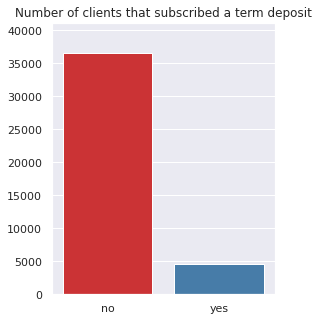

In [11]:
# check for imbalance in target variable
plt.figure(figsize=(4,5))
sns.countplot(data=df, x='y')
plt.title('Number of clients that subscribed a term deposit')
plt.xlabel(None)
plt.ylabel(None)
plt.ylim(0, df.shape[0])

plt.show()

We can see that most clients have not subscribed to a term deposit and the ratio is about `7:1`\
That means we need to stratify when splitting

## Splitting Dataset

We need to split the dataset into inference, train and test sets before we do any EDA.\
We do our EDA on the train set so as to not have any bias towards the whole dataset.

### Sample data for inference

In [12]:
# sample dataset for inference
df_inf = df.sample(10, random_state=42)

# remove inference set from original dataset
df_train_test = df.drop(df_inf.index).reset_index(drop=True)

# reset index for inference set
df_inf = df_inf.reset_index(drop=True)

print('df_inf Size:', df_inf.shape)

df_inf Size: (10, 21)


### Split train and test set


Since the target variable is imbalanced, we use stratified sampling

In [13]:
# we use stratified sampling to ensure that the distribution of the target variable is balanced
df_train, df_test = train_test_split(
    df_train_test,
    test_size=0.20,
    random_state=42,
    stratify=df_train_test['y']
)

print('df_train Size:', df_train.shape)
print('df_test Size:', df_test.shape)

df_train Size: (32942, 21)
df_test Size: (8236, 21)


In [14]:
# backup the train set that we are gonna perform EDA on
df_train_ori = df_train.copy()

# 4. Exploratory Data Analysis

## Number of clients that subscribed a term deposit

We have checked this before sampling\
Now let's check again for the train set

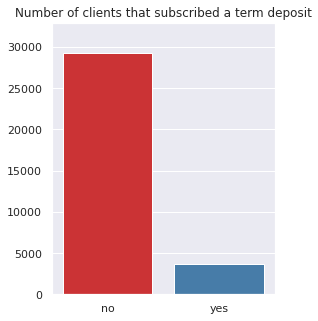

In [15]:
# plot the number of clients that subcribed a term deposit
plt.figure(figsize=(4,5))
sns.countplot(data=df_train, x='y')
plt.title('Number of clients that subscribed a term deposit')
plt.xlabel(None)
plt.ylabel(None)
plt.ylim(0, df_train.shape[0])

plt.show()

Most clients did not subscribe to a term deposit and the ratio is about `7:1`\
Seems like the telemarketing team needs to work harder, or there needs to be a change of strategy

## Age

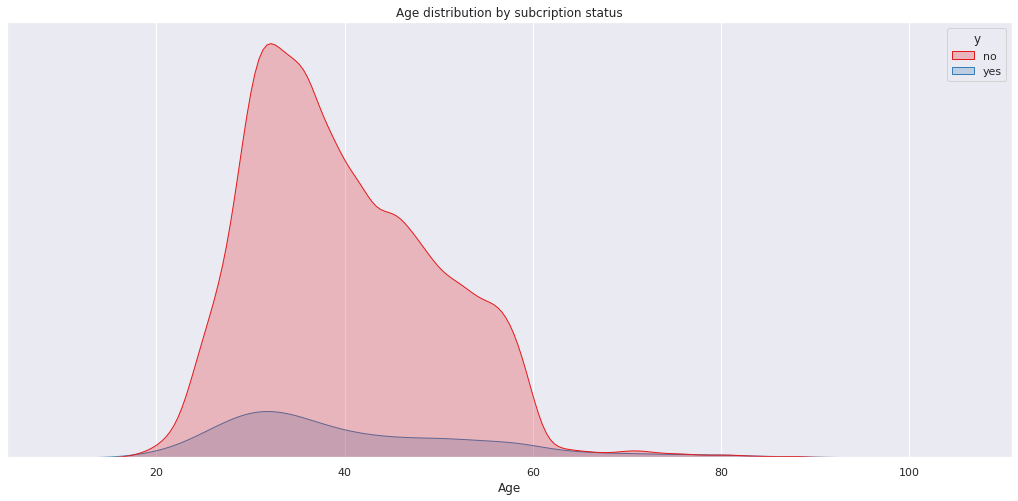

In [16]:
# plot distribution of age grouped by subcription status
plt.figure(figsize=(18, 8))
sns.kdeplot(data=df_train, x='age', hue='y', shade=True)
plt.title('Age distribution by subcription status')
plt.xlabel('Age')
plt.yticks([])
plt.ylabel(None)

# plt.legend(labels=['Default', 'Not Default'])
plt.show()

We can see that there's not much of a difference between the clients who subscribed and the clients who did not subscribed.\
Most clients are around the age of mid 30s to 50s

## Job

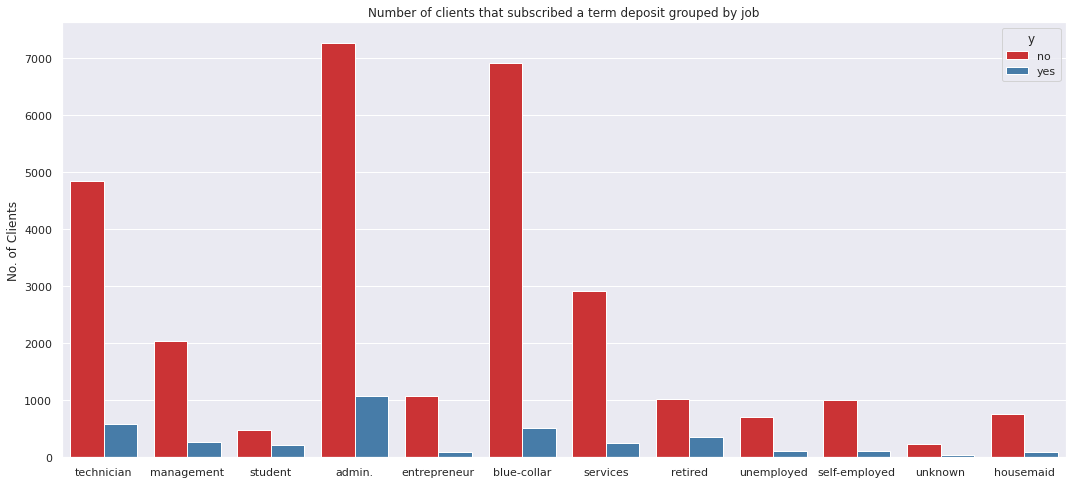

In [17]:
# plot number of clients that subcribed a term deposit grouped by job
plt.figure(figsize=(18,8))
sns.countplot(data=df_train, x='job', hue='y')
plt.title('Number of clients that subscribed a term deposit grouped by job')
plt.xlabel(None)
plt.ylabel("No. of Clients")

plt.show()

We can see that most clients work as an admin, followed by blue-collared workers. It doesn't seem that there's anything prominent that we can see from this observation that would relate with the target variable

There are only a handful of people whose job is unknown. Let's check in more detail

In [18]:
# check the percentage of clients that have `unknown` as education level
df_train['job'].value_counts()['unknown'] / df_train.shape[0] * 100

0.8044441746099205

There's only about 0.8% of these clients whose jobs we do not know

## Education

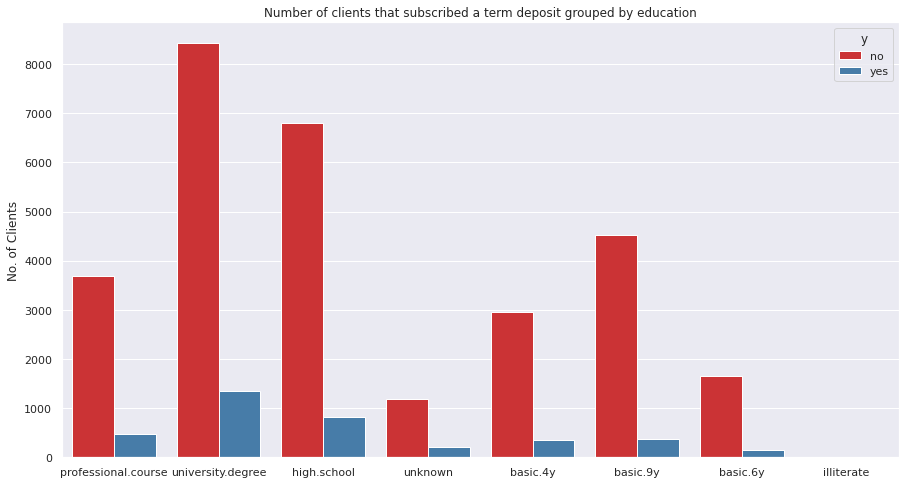

In [19]:
# plot number of clients that subcribed a term deposit grouped by education
plt.figure(figsize=(15,8))
sns.countplot(data=df_train, x='education', hue='y')
plt.title('Number of clients that subscribed a term deposit grouped by education')
plt.xlabel(None)
plt.ylabel("No. of Clients")

plt.show()

We can see that the number of clients who are illiterate are so small the plot couldn't even be seen clearly.\
The `unknown` category comprises of about 14% of `university` category total. Let's check how this category comprises of the whole dataset

In [20]:
# check the percentage of clients that have `unknown` as education level
df_train['education'].value_counts()['unknown'] / df_train.shape[0] * 100

4.207394815129621

So we can see that it's about 4% out of the whole dataset. There's not too many of them

## Marital Status

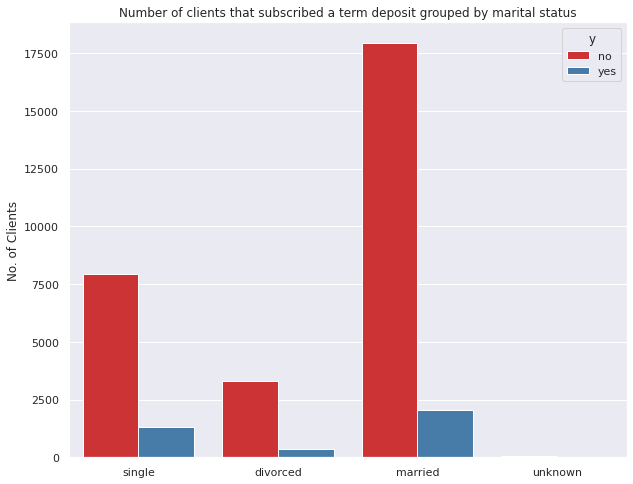

In [21]:
# plot number of clients that subcribed a term deposit grouped by marital status
plt.figure(figsize=(10,8))
sns.countplot(data=df_train, x='marital', hue='y')
plt.title('Number of clients that subscribed a term deposit grouped by marital status')
plt.xlabel(None)
plt.ylabel("No. of Clients")

plt.show()

We can see that most clients are married. The clients whose marital status `unknown` are only a handful of people.\
There doesn't seem to be any tendency for subscribing that are different in each status

In [22]:
# check the percentage of clients that have `unknown` as marital status
df_train['marital'].value_counts()['unknown'] / df_train.shape[0] * 100

0.19428085726428268

There is only 0.19% of clients that have `unknown` as marital status.

## Default Status, Housing Status, Loan Status

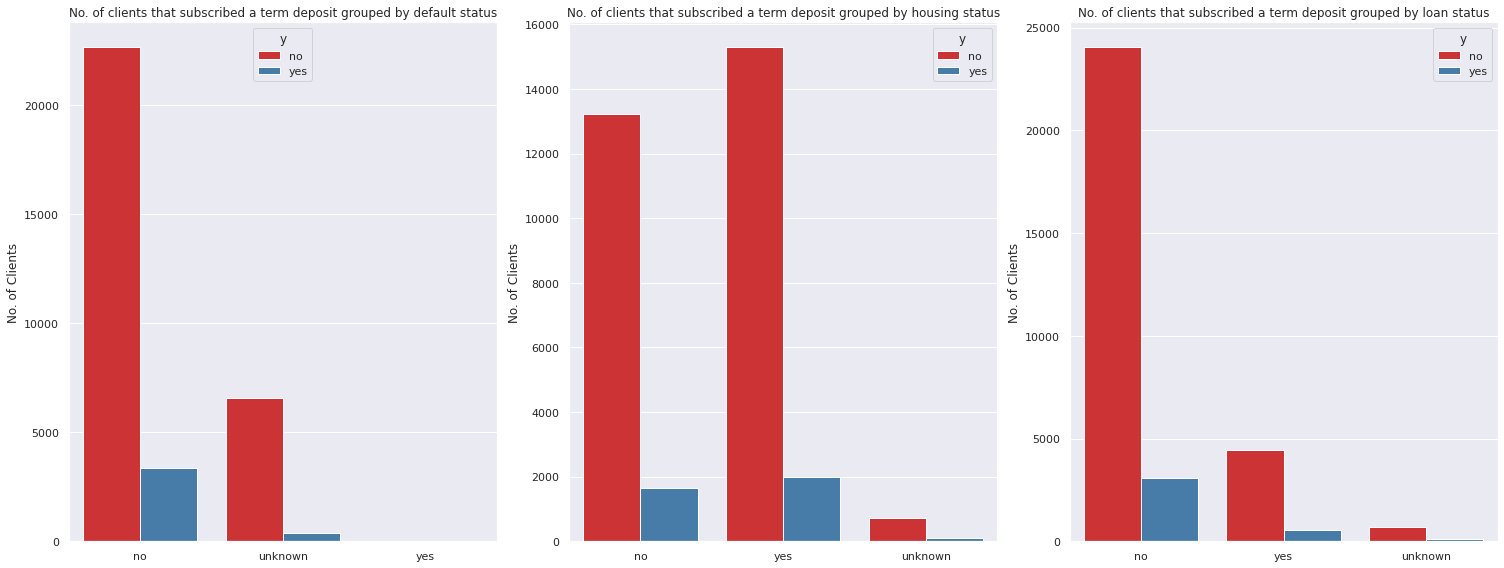

In [23]:
# plot number of clients that subcribed a term deposit grouped by statuses

plt.figure(figsize=(21,8))
for i, col in enumerate(['default', 'housing', 'loan']):
    sns.countplot(data=df_train, x=col, hue='y', ax=plt.subplot(1,3,i+1))
    plt.title('No. of clients that subscribed a term deposit grouped by {} status'.format(col))
    plt.xlabel(None)
    plt.ylabel("No. of Clients")

plt.tight_layout()
plt.show()


- We can see here that most clients are not defaulted on their loans. However, there are quite a lot of clients whom we do not know their default status as well.
- Most clients have a house loan, however the difference between those clients who have a house loan and those who do not is not very significant.
- Most clients do not have a personal loan
- We can therefore conclude that most of our clients mostly take loans for their houses

## Duration

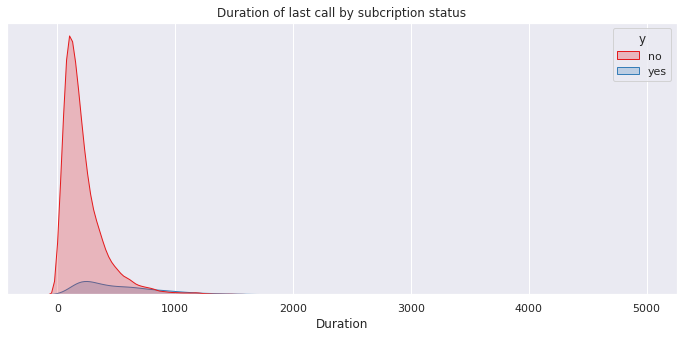

In [24]:
# plot the distribution of duration of last call grouped by subcription status
plt.figure(figsize=(12,5))
sns.kdeplot(data=df_train, x='duration', hue='y', shade=True)
plt.title('Duration of last call by subcription status')
plt.xlabel('Duration')
plt.yticks([])
plt.ylabel(None)

plt.show()

Most calls last below 500 seconds, which is around 7 minutes. Seems like the majority calls for people who chose not to subscribe lasted around 3 minutes

## Days passed since last call

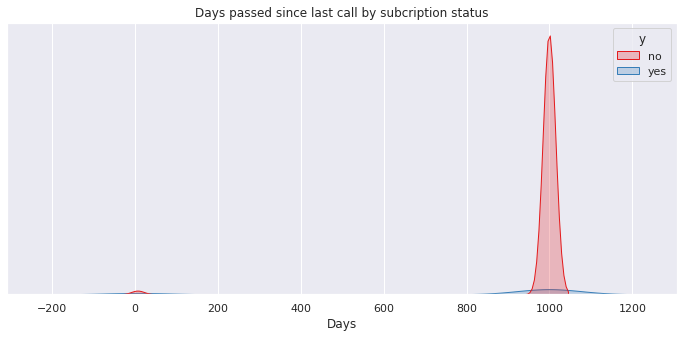

In [25]:
# plot distribution of days passed since last call grouped by subcription status
plt.figure(figsize=(12,5))
sns.kdeplot(data=df_train, x='pdays', hue='y', shade=True)
plt.title('Days passed since last call by subcription status')
plt.xlabel('Days')
plt.yticks([])
plt.ylabel(None)

plt.show()

Since the value of 999 is the center of our distribution, that means that most people have not been contacted previously\
Let's plot another graph without the 999 to see the clients which have been contacted

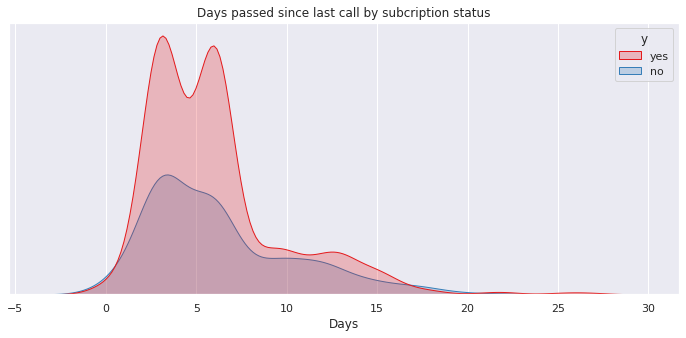

In [26]:
# plot distribution of days passed since last call grouped by subcription status
plt.figure(figsize=(12,5))
sns.kdeplot(data=df_train[df_train['pdays'] != 999], x='pdays', hue='y', shade=True)
plt.title('Days passed since last call by subcription status')
plt.xlabel('Days')
plt.yticks([])
plt.ylabel(None)

plt.show()

We can see that it's mostly been around 5 days since last call. Many of the clients were last contacted under 30 days.\
That means we need to find other clients to contact. Those clients which have not been previously contacted before

## Outcome of Previous Campaign

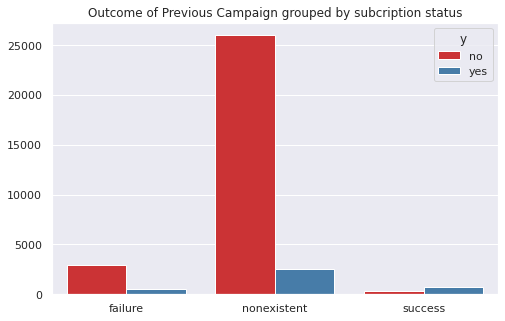

In [27]:
# plot distribution of poutcome grouped by subcription status
plt.figure(figsize=(8,5))
sns.countplot(data=df_train, x='poutcome', hue='y')
plt.title('Outcome of Previous Campaign grouped by subcription status')
plt.xlabel(None)
# plt.yticks([])
plt.ylabel(None)

plt.show()

We already saw that most of the clients have not been previously contacted.\
So it makes sense that most of the results from the previous campaign are non existent

## Socio Economic Indicators

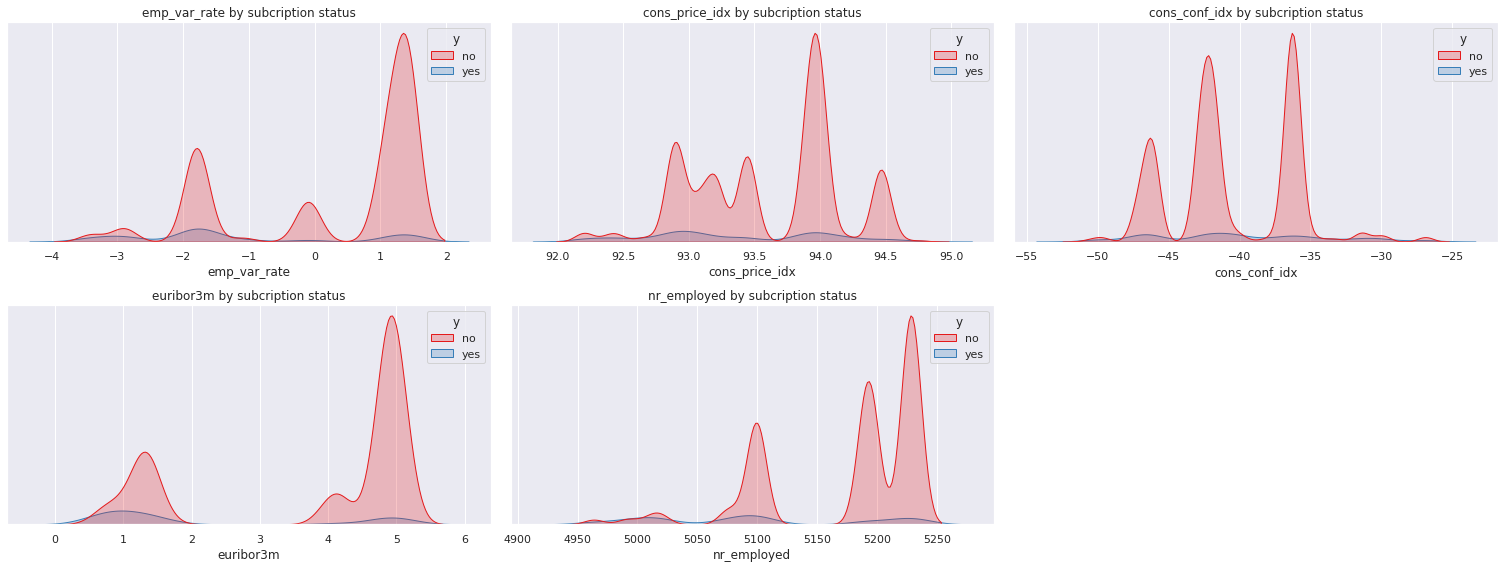

In [28]:
# plot distribution of socio economic indicators
plt.figure(figsize=(21,8))
for i, col in enumerate(['emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']):
    sns.kdeplot(data=df_train, x=col, hue='y', shade=True, ax=plt.subplot(2,3,i+1))
    plt.title('{} by subcription status'.format(col))
    plt.xlabel(col)
    plt.yticks([])
    plt.ylabel(None)

plt.tight_layout()
plt.show()

There doesn't seem to be any prominent difference we can easily point out on all socio economic indicators between target variables.\
The distribution may seem more dispersed for the `no` target variable. However, this is solely from the fact that there were many more clients who did not subscribed compared to those who did. So it's bound that the economic indicators varied even more.\
If we look closer, for example on the `cons_price_idx` and `euribor3m`, we can see that the `yes` target variable have around the same location where the data centers

# 5. Data Preprocessing

In [29]:
# restore the train set from the backup
df_train = df_train_ori.copy()

In [30]:
# split between features and target
X_train = df_train.drop(['y'], axis=1)
y_train = df_train['y'].copy()

X_test = df_test.drop(['y'], axis=1)
y_test = df_test['y'].copy()

## Categorizing Features

Categorize the features based on the variable type of the features and the data it represents
- Numeric (Interval): Features which have equally spaced interval between unique values
- Categorical (Nominal): Features which have no intrinsic ordering to the unique values
- Ordinal: Features which have clear ordering but do not have equally spaced intervals between unique values

In [31]:
# categorizing features
num_cols = [
    'age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
    'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'
]

nom_cols = [
    'job', 'marital', 'default', 'housing', 'loan', 'contact',
    'month', 'day_of_week', 'poutcome'
]

ord_cols = ['education']

## Handling Outliers

In [32]:
# check outlier summary only on numerical features
outlier_summary(X_train[num_cols], 1.5)

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,age,0.78,skewed,378,1.15
1,duration,3.31,skewed,2365,7.18
2,campaign,4.71,skewed,1935,5.87
3,pdays,-4.93,skewed,1210,3.67
4,previous,3.88,skewed,4499,13.66
5,emp_var_rate,-0.72,skewed,0,0.00
6,cons_price_idx,-0.23,normal,0,0.00
7,cons_conf_idx,0.30,normal,0,0.00
8,euribor3m,-0.70,skewed,0,0.00
9,nr_employed,-1.04,skewed,0,0.00


1. `Trimming`: if outliers' percentage < 5%
2. `Capping`: if outliers' percentage 5% - 15%
3. `None`: if outliers' percentage > 15%

In [33]:
# check outlier details
check_outlier(X_train[num_cols], 1.5)

,feats,upper_bound,lower_bound,tot_right_tail,tot_left_tail,tot_right_tail_pct,tot_left_tail_pct,tot_outlier,tot_outlier_pct
0,age,69.50,9.50,378,0,1.15,0.00,378,1.15
1,duration,642.00,-222.00,2365,0,7.18,0.00,2365,7.18
2,campaign,6.00,-2.00,1935,0,5.87,0.00,1935,5.87
3,pdays,999.00,999.00,0,1210,0.00,3.67,1210,3.67
4,previous,0.00,0.00,4499,0,13.66,0.00,4499,13.66
5,emp_var_rate,6.20,-6.60,0,0,0.00,0.00,0,0.00
6,cons_price_idx,95.31,91.84,0,0,0.00,0.00,0,0.00
7,cons_conf_idx,-26.62,-54.39,0,0,0.00,0.00,0,0.00
8,euribor3m,10.39,-4.08,0,0,0.00,0.00,0,0.00
9,nr_employed,5421.60,4905.60,0,0,0.00,0.00,0,0.00


Trim and cap the outliers

In [34]:
# print X_train and y_train shape before trimming and capping
print('X_train shape before trimming and capping:', X_train.shape)
print('y_train shape before trimming and capping:', y_train.shape)

# trim and cap outliers
X_train, y_train = trim_cap_outliers(
    X_train,
    exception_list = nom_cols + ord_cols,
    fold=1.5,
    target=y_train
)

# print X_train and y_train shape after trimming and capping
print('X_train shape after trimming and capping:', X_train.shape)
print('y_train shape after trimming and capping:', y_train.shape)

X_train shape before trimming and capping: (32942, 20)
y_train shape before trimming and capping: (32942,)
X_train shape after trimming and capping: (31430, 20)
y_train shape after trimming and capping: (31430,)


## Handling Missing Values


In [35]:
# check missing values in train set
check_missing(X_train)

,feats,tot_missing,tot_missing_pct


In [36]:
# check missing values in train target
y_train.isna().sum()

0

In [37]:
# check missing values in test set
check_missing(X_test)

,feats,tot_missing,tot_missing_pct


In [38]:
# check missing values in test target
y_test.isna().sum()

0

We have no `NaN` values in the train set nor test set. However, we do have missing values in the form of `unknown` and 999, so let's check for that

In [39]:
# check for special missing values
check_missing_special(
    X_train,
    999, 'unknown', 'nonexistent'
).style.format({'tot_missing_pct': '{:.2f}%'})

,feats,tot_missing,tot_missing_pct
0,job,241,0.77%
1,marital,60,0.19%
2,education,1276,4.06%
3,default,6858,21.82%
4,housing,774,2.46%
5,loan,774,2.46%
6,pdays,31430,100.00%
7,poutcome,31430,100.00%


Since we have more than 90% of missing values in the feature `pdays` and `poutcome`, I'm not going to include it as a predictor. These two features are higly dependent since they are the results of last contact

For other features' missing values, aside from `default`, I'm going to impute them with the most frequent value in their subsequent features
`defaul` has around 21.82% of the dataset, which I think would be sufficient to stand as its own category, where it's also possible that we do not know the default status for a client, but still has to make a decision anyway

The missing values is not `NaN`, but `unknown`. So I'm going to replace these `unknown` values in those specific features with `NaN` to prepare for imputation

In [40]:
# list of features that we want to impute
impute_cols = ['job', 'marital', 'education', 'housing', 'loan']

In [41]:
# print shape before preparing for imputation
print('X_train shape before preparing for imputation:', X_train.shape)
print('X_test shape before preparing for imputation:', X_test.shape)

# perform prepare_imputation on X_train and X_test
X_train = prepare_imputation(X_train, impute_cols)
X_test = prepare_imputation(X_test, impute_cols)

# print shape after preparing for imputation
print('X_train shape after preparing for imputation:', X_train.shape)
print('X_test shape after preparing for imputation:', X_test.shape)

X_train shape before preparing for imputation: (31430, 20)
X_test shape before preparing for imputation: (8236, 20)
X_train shape after preparing for imputation: (31430, 20)
X_test shape after preparing for imputation: (8236, 20)


In [42]:
# create imputer object
unknown_imputer = CategoricalImputer(
    imputation_method='frequent',
    variables=impute_cols
)

This object will later be run in a pipeline with scaling, which are the pre-oversampling procedures

## Feature Selection

### Heatmap Correlation Matrix for Numerical Features

We look at the Spearman's correlation matrix to find out the relation between features and target

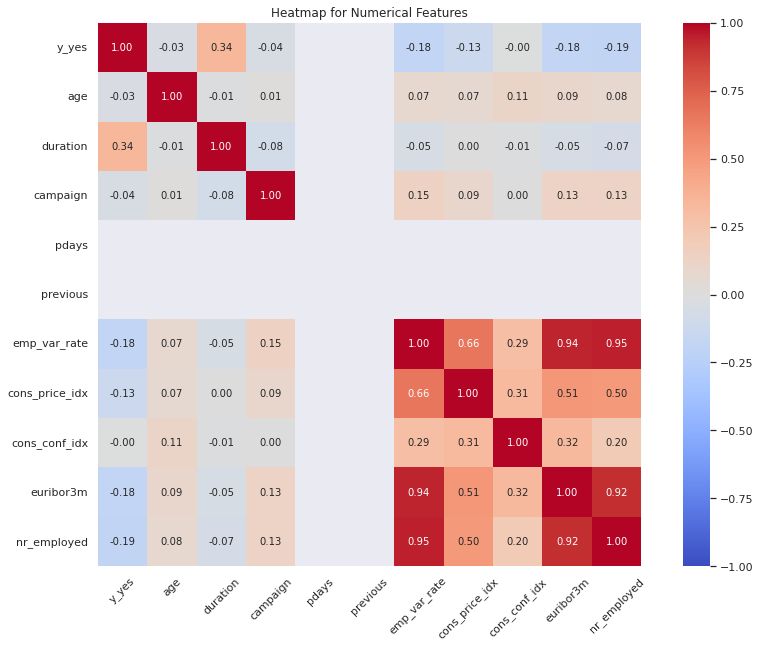

In [43]:
# Heatmap Correlation Matrix
plt.figure(figsize=(15,10))

sns.heatmap(
    pd.concat([
        pd.get_dummies(y_train, prefix='y', drop_first=True),
        X_train[num_cols]], axis=1
    ).corr('spearman'),
    annot=True, vmin=-1, vmax=1, fmt='.2f', square=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Heatmap for Numerical Features')

plt.show()


- `y_yes` is a dummy variable which represents the target, with a value of `0 being no and 1 being yes`
- There are low spearman correlations amongst features and target, with the highest being `duration`
- But we have mentioned this before that `duration` is interdependent with the target variable `y`. Therefore, we are going to drop this feature
- We can see that social economic context features are quite highly correlated with each others. This are new features that were not available during the first research published
- We can also see that `pdays` and `previous` are highly dependent and also homogenous after outlier handling, since they are both features which resulted from the last contact. Since I'm dropping `pdays` because they have a lot of missing values, I will be dropping `previous` as well.

### Categorizing Selected Features

In [44]:
# display outlier summary
outlier_summary(X_train[num_cols], 1.5).sort_values(by='dist')

,feats,skew,dist,tot_outlier,tot_outlier_pct
0,age,0.43,normal,24,0.08
3,pdays,0.00,normal,0,0.00
4,previous,0.00,normal,0,0.00
6,cons_price_idx,-0.22,normal,0,0.00
7,cons_conf_idx,0.28,normal,261,0.83
1,duration,1.05,skewed,0,0.00
2,campaign,1.18,skewed,0,0.00
5,emp_var_rate,-0.83,skewed,0,0.00
8,euribor3m,-0.85,skewed,0,0.00
9,nr_employed,-1.13,skewed,0,0.00


In [45]:
# create list of numerical features with normal distribution
num_cols_norm = [
    'age', 'cons_price_idx', 'cons_conf_idx'
]

# create list of numerical features with skew
num_cols_skew = [
    'campaign', 'emp_var_rate', 'euribor3m', 'nr_employed'
]

# create final list of nominal features
nom_cols = [
    'job', 'marital', 'default', 'housing', 'loan', 'contact',
    'month', 'day_of_week'
]

# create final list of ordinal features
ord_cols = ['education']

Great! We have finalized our feature list.
We also separated numerical features with different types of distribution just in case we want to scale them using different methods

### List of Features

These are the predictors we're going to use

In [46]:
# print out list of predictors
print('Numerical Features:')
print(num_cols_norm + num_cols_skew)
print('=' * 100)
print('Categorical Features:')
print(nom_cols)
print('=' * 100)
print('Ordinal Features:')
print(ord_cols)

Numerical Features:
['age', 'cons_price_idx', 'cons_conf_idx', 'campaign', 'emp_var_rate', 'euribor3m', 'nr_employed']
Categorical Features:
['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']
Ordinal Features:
['education']


Prepare the order for ordinal feature `education`

In [47]:
# prepare education ordered categorical variable
education_order = [
    "illiterate",
    "basic.4y",
    "basic.6y",
    "basic.9y",
    "high.school",
    "professional.course",
    "university.degree",
]

## Feature Engineering

### Prepare The Necessary Objects

Declare the various objects, like scaler and encoder we might use
- All categorical features will use one hot encoder
- Ordinal features which is `education` will use ordinal encoder

In [48]:
# declare standard scaler
std_sc = StandardScaler()

# declare min max scaling
mm_sc = MinMaxScaler()

# declare one hot encoder
ohe_enc = OneHotEncoder(handle_unknown='ignore')

# declare ordinal encoder
ord_enc = OrdinalEncoder(categories=[education_order])

# declare label encoder
label_enc = LabelEncoder()


Create ColumnTransformer, SMOTENC, and PCA objects
- In ColumnTransformer, we will design so that our dataset will have the categorical features lined up after the numerical ones

In [49]:
# create column transformer object using min max scaler
scale_mm = ColumnTransformer([
    ('num_norm', std_sc, num_cols_norm),
    ('num_skew', mm_sc, num_cols_skew),
    ('nom', 'passthrough', nom_cols),
    ('ord', 'passthrough', ord_cols)
])

# create column transformer object for use after oversampling
encode = ColumnTransformer([
    ('num', 'passthrough', slice(0, 7)),
    ('nom', ohe_enc, slice(7, 15)),
    ('ord', ord_enc, [15])
])

# create smotenc object
# categorical features will be put at the end, after the numerical ones
smotenc = SMOTENC(
    categorical_features= list(range(7, 16)),
    random_state=42
)

# create pca object
pca = PCA(n_components=0.8, random_state=42)


In [50]:
# create pipeline object for imputing and scaling
imputer_scaler_pipe = Pipeline([
    ('imputer', unknown_imputer),
    ('scale', scale_mm)
])

### Scaling

We need to scale all numerical columns before oversampling

In [51]:
# scale numeric features 
X_train_scaled = imputer_scaler_pipe.fit_transform(X_train)
X_test_scaled = imputer_scaler_pipe.transform(X_test)

# print shape
print('X_train_scaled shape:', X_train_scaled.shape)
print('X_test_scaled shape:', X_test_scaled.shape)

X_train_scaled shape: (31430, 16)
X_test_scaled shape: (8236, 16)


### Oversampling

Since our data is imbalance, we need to perform oversampling

In [52]:
# oversampling using SMOTE
X_train_balanced, y_train_balanced = smotenc.fit_resample(X_train_scaled, y_train)

# print shape after oversampling
print('X_train_balanced shape:', X_train_balanced.shape)
print('y_train_balanced shape:', y_train_balanced.shape)

X_train_balanced shape: (57238, 16)
y_train_balanced shape: (57238,)


### Encoding

In [53]:
# encode categorical features
X_train_encoded = encode.fit_transform(X_train_balanced)
X_test_encoded = encode.transform(X_test_scaled)

# encode labels
y_train_final = label_enc.fit_transform(y_train_balanced)
y_test_final = label_enc.transform(y_test)

# print shape
print('X_train_encoded shape:', X_train_encoded.shape)
print('X_test_encoded shape:', X_test_encoded.shape)
print('y_train_final shape:', y_train_final.shape)
print('y_test_final shape:', y_test_final.shape)

X_train_encoded shape: (57238, 46)
X_test_encoded shape: (8236, 46)
y_train_final shape: (57238,)
y_test_final shape: (8236,)


### Dimensionality Reduction

In [54]:
# perform dimensionality reduction
X_train_final = pca.fit_transform(X_train_encoded)
X_test_final = pca.transform(X_test_encoded)

# print shape
print('X_train_final shape:', X_train_final.shape)
print('y_train_final shape:', y_train_final.shape)
print('X_test_final shape:', X_test_final.shape)
print('y_test_final shape:', y_test_final.shape)

X_train_final shape: (57238, 10)
y_train_final shape: (57238,)
X_test_final shape: (8236, 10)
y_test_final shape: (8236,)


We can see that we have reduced the number of features from 50 to 10. The dataset is now about 20% of its original size. Quite a good compression

Let's see how it would look like in 2D

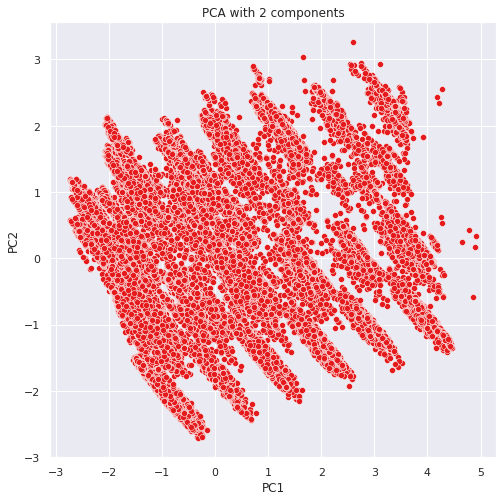

In [55]:
# plot pca with 2 components
pca_2d = PCA(n_components=2, random_state=42)
X_2d  = pca_2d.fit_transform(encode.fit_transform(X_train_balanced))

plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with 2 components')
plt.show()

Preprocessing is finished

# 6. Model Definition

- Target: Predicting whether clients will subscribe to a term deposit

    The target that we're going to predict is a label, which means we are going to make a classification model.
    In this case, we want to minimize the situation in which we incorrectly predicts a client won't subscribe (when the client is in fact will), or as in the statistical term, **False Negatives**.\
    This prediction is made so that we can target our clients and prioritize contacting those who have a high chance of subscribing. We don't want to classify a client as not potential when in fact, they should be contacted right away.

- Predictors: The features I'm going to use are
    - Numerical Features:
        - ['age', 'cons_price_idx', 'cons_conf_idx', 'campaign', 'emp_var_rate', 'euribor3m', 'nr_employed']
    - Categorical Features:
        - ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']
    - Ordinal Features:
        - ['education']


- Models: The Supervised Learning Algorithms I'm going to test
    - Logistic Regression
    - Support Vector Machine
    - Random Forest
    - XGBoost

In [56]:
# declare logreg model
logreg = LogisticRegression(random_state=42)

# declare svm model
svm = SVC(random_state=42)

# declare random forest model
rf = RandomForestClassifier(random_state=42)

# declare xgboost model
xgb = XGBClassifier(random_state=42, eval_metric='error')

# 7. Model Training

In [57]:
# create a dictionary of models
models = {
    'logreg': logreg,
    'svm': svm,
    'rf': rf,
    'xgb': xgb
}

## Cross Validating Base Models

Since the dataset is imbalance, we are going to evaluate our models based on **F1 Score**\
It's also important that we reduce the number of *False Negatives*, hence a high **Recall** is also important

In [58]:
# create a dict to store the cross validation scores
cv_results = {
    'models': [],
    'f1_score_mean': [],
    'f1_score_std': [],
    'recall_score_mean': [],
    'recall_score_std': []
} 

# loop over each each models and perform cross validation
for name, model in models.items():
    # fit the model
    model.fit(X_train_final, y_train_final)
    # get cross validation scores
    scores = cross_validate(
        model, X_train_final, y_train_final,
        scoring=['f1_weighted', 'recall'],
        cv=3
    )

    # store the cross validation scores
    cv_results['models'].append(name)
    cv_results['f1_score_mean'].append(scores['test_f1_weighted'].mean().round(2))
    cv_results['f1_score_std'].append(scores['test_f1_weighted'].std().round(4))
    cv_results['recall_score_mean'].append(scores['test_recall'].mean().round(2))
    cv_results['recall_score_std'].append(scores['test_recall'].std().round(4))

# create a dataframe from the dict
cv_results_df = pd.DataFrame(cv_results)

# 8. Model Evaluation

In [59]:
# display the dataframe sorted by f1 score
cv_results_df.sort_values(by=['f1_score_mean', 'recall_score_mean'], ascending=False)

,models,f1_score_mean,f1_score_std,recall_score_mean,recall_score_std
2,rf,0.89,3.09e-02,0.89,0.07
3,xgb,0.84,2.14e-02,0.84,0.05
1,svm,0.74,7.90e-03,0.70,0.01
0,logreg,0.69,7.80e-03,0.69,0.01


- Based on the cross validation score of `f1_weighted` and `recall` we can see that **Random Forest and XGBoost** are the top two
- For this research, because of time constraint and resources, we are going to finetune only one of our algorithm
- In this case, I'm going to choose **Random Forest**. However, be mindful that **XGBoost** should also be further delved into

## Hyperparameter Tuning


In [60]:
# create parameter grid for random forest
param_grid = {
    'max_depth': [3, 5, 7],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
}

In [61]:
# create randomized search object
rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1_weighted',
    random_state=42,
    cv=3
)

In [62]:
%%time

# perform randomized search
rs.fit(X_train_final, y_train_final)

CPU times: user 3min 46s, sys: 296 ms, total: 3min 46s
Wall time: 3min 46s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'max_features': [1, 2, 3],
                                        'min_samples_leaf': [1, 2, 3]},
                   random_state=42, scoring='f1_weighted')

In [63]:
# print the best parameters
print(f'Best parameters: {rs.best_params_}')

# print the best score
print(f'Best score: {rs.best_score_:.4f}')

Best parameters: {'min_samples_leaf': 1, 'max_features': 3, 'max_depth': 7}
Best score: 0.7501


In [64]:
# assign the best estimator to the final model
final_rf = rs.best_estimator_

Running this grid search resulted in:
- Around 4 minutes of runtime
- Best parameters: `{'min_samples_leaf': 1, 'max_features': 3, 'max_depth': 7}`
- Best score: `0.7501`

## Evaluate Hyperparameter Tuning Results

In [65]:
# predict train set using the base model
y_pred_train_rf = rf.predict(X_train_final)

# predict test set using the base model
y_pred_test_rf = rf.predict(X_test_final)

# predict train set using the final model
y_pred_train_final_rf = final_rf.predict(X_train_final)

# predict test set using the final model
y_pred_test_final_rf = final_rf.predict(X_test_final)

In [66]:
# prepare target names for classification report
target_names = ["Won't Subscribe", "Will Subscribe"]

In [67]:
# create a dictionary containing the list of base and final predictions
predictions = {
    'Base Random Forest': [y_pred_train_rf, y_pred_test_rf],
    'Final Random Forest': [y_pred_train_final_rf, y_pred_test_final_rf]
}

### Summary of F1 and Recall Score

In [68]:
# create a dict to store the classification report summarized
report_summary = {
    'models': [],
    'f1_scores_train': [],
    'f1_scores_test': [],
    'recall_scores_train': [],
    'recall_scores_test': [],
    'roc_auc_scores_train': [],
    'roc_auc_scores_test': []
} 

# loop over each each models and perform cross validation
for name, preds in predictions.items():
    # get f1 score training set
    f1_score_train = f1_score(y_train_final, preds[0], average='weighted')
    # get f1 score test set
    f1_score_test = f1_score(y_test_final, preds[1], average='weighted')
    # get recall score training set
    recall_score_train = recall_score(y_train_final, preds[0], average='weighted')
    # get recall score test set
    recall_score_test = recall_score(y_test_final, preds[1], average='weighted')
    # get roc auc score training set
    roc_auc_score_train = roc_auc_score(y_train_final, preds[0], average='weighted')
    # get roc auc score test set
    roc_auc_score_test = roc_auc_score(y_test_final, preds[1], average='weighted')

    # store the scores
    report_summary['models'].append(name)
    report_summary['f1_scores_train'].append(f1_score_train)
    report_summary['f1_scores_test'].append(f1_score_test)
    report_summary['recall_scores_train'].append(recall_score_train)
    report_summary['recall_scores_test'].append(recall_score_test)
    report_summary['roc_auc_scores_train'].append(roc_auc_score_train)
    report_summary['roc_auc_scores_test'].append(roc_auc_score_test)

# create a dataframe from the dict
report_summary_df = pd.DataFrame(report_summary)

In [69]:
# display the report summary
report_summary_df

,models,f1_scores_train,f1_scores_test,recall_scores_train,recall_scores_test,roc_auc_scores_train,roc_auc_scores_test
0,Base Random Forest,1.00,0.85,1.00,0.84,1.00,0.63
1,Final Random Forest,0.76,0.80,0.76,0.77,0.76,0.71


- We can see from the comparison between the train score and the test score for each model to determine whether the model is a good fit
- We conclude that the base model is overfit as the f1 train score are way higher than the f1 test score
- The *Final Random Forest* method which have been tuned resulted in a good fit as the f1 and recall test scores are higher than their respective train scores counterpart.
- There's also not that much of a difference between the train and test scores
- Therefore, the *Final Random Forest* will be our main model to further analyze

### Detailed Evaluation for Random Forest Classifier

In [70]:
# print out the classification report for each model
for name, preds in predictions.items():
    print(f'\nClassification Report for {name} Training Set:')
    print(classification_report(y_train_final, preds[0], target_names=target_names))
    print(f'\nClassification Report for {name} Test Set:')
    print(classification_report(y_test_final, preds[1], target_names=target_names))


Classification Report for Base Random Forest Training Set:
                 precision    recall  f1-score   support

Won't Subscribe       1.00      1.00      1.00     28619
 Will Subscribe       1.00      1.00      1.00     28619

       accuracy                           1.00     57238
      macro avg       1.00      1.00      1.00     57238
   weighted avg       1.00      1.00      1.00     57238


Classification Report for Base Random Forest Test Set:
                 precision    recall  f1-score   support

Won't Subscribe       0.92      0.90      0.91      7308
 Will Subscribe       0.32      0.35      0.33       928

       accuracy                           0.84      8236
      macro avg       0.62      0.63      0.62      8236
   weighted avg       0.85      0.84      0.85      8236


Classification Report for Final Random Forest Training Set:
                 precision    recall  f1-score   support

Won't Subscribe       0.74      0.80      0.77     28619
 Will Subscribe   

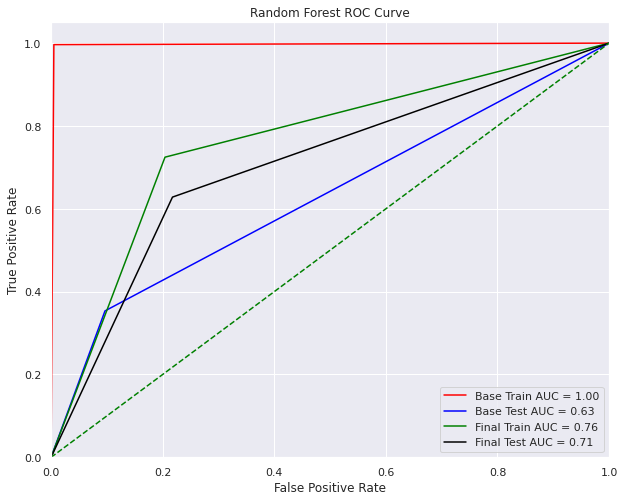

In [71]:
# plot roc curve for train set
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train_final, y_pred_train_rf)
# calculate auc score for train set
roc_auc_train_rf = auc(fpr_train_rf, tpr_train_rf)

# plot roc curve for test set
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test_final, y_pred_test_rf)
# calculate auc score for test set
roc_auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

# plot roc curve for train set using the final model
fpr_train_final_rf, tpr_train_final_rf, _ = roc_curve(y_train_final, y_pred_train_final_rf)
# calculate auc score for train set using the final model
roc_auc_train_final_rf = auc(fpr_train_final_rf, tpr_train_final_rf)

# plot roc curve for test set using the final model
fpr_test_final_rf, tpr_test_final_rf, _ = roc_curve(y_test_final, y_pred_test_final_rf)
# calculate auc score for test set using the final model
roc_auc_test_final_rf = auc(fpr_test_final_rf, tpr_test_final_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_train_rf, tpr_train_rf, color='red', label=f'Base Train AUC = {roc_auc_train_rf:.2f}')
plt.plot(fpr_test_rf, tpr_test_rf, color='blue', label=f'Base Test AUC = {roc_auc_test_rf:.2f}')
plt.plot(fpr_train_final_rf, tpr_train_final_rf, color='green', label=f'Final Train AUC = {roc_auc_train_final_rf:.2f}')
plt.plot(fpr_test_final_rf, tpr_test_final_rf, color='black', label=f'Final Test AUC = {roc_auc_test_final_rf:.2f}')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()

- Looking at the classification report and the AUC score, we can see that tuning has made the model from overfit to a good fit. Hence viable to be run. However, we still need to look whether the metrics is good enough for our purpose
- We need to detect the potential of subscribing as much as possible, therefore we need to minimize **False Negatives**, hence we need a high recall score
- We successfully increased the recall score after tuning, as we can see that we now have a recall score of `0.63`
- This however, is not enough for us, as just having a few **False Negatives** could make us lose precious revenues
- Therefore, even though this model is now a good fit and we have successfully minimized the **False Negatives**, it is still not up to the standard needed and much improvements have to be made

## Save The Final Model

We'll create a pipeline containing the steps performed post-oversampling to modeling\
We also need to save our imputer-scaler-pipeline separately since it was performed pre-oversampling

In [72]:
# create a pipeline for the final model
final_rf_pipe = Pipeline([
    ('encode', encode),
    ('pca', pca),
    ('final_rf', final_rf)
])

# fit the pipeline to the imputed, scaled and oversampled training data
final_rf_pipe.fit(X_train_balanced, y_train_final)

Pipeline(steps=[('encode',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  slice(0, 7, None)),
                                                 ('nom',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  slice(7, 15, None)),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                              'high.school',
                                                                              'professional.course',
                                                                              'university.degree']]),
                                                  [15])])),
                ('pca', PCA(n_components=0.8, random_state=42)),
                ('final_rf',
                 RandomForestClassifier(max_depth=7, max_features=3,
                                        random_state=42))])

In [73]:
# prepare directory for saving model
model_dir = 'models'
scaler_name = 'imputer_scaler_pipe.pkl'
model_name = 'final_rf_pipe.pkl'

# create directory if it does not exist
Path(model_dir).mkdir(parents=True, exist_ok=True)

# save models
joblib.dump(imputer_scaler_pipe, Path(model_dir, scaler_name))
joblib.dump(final_rf_pipe, Path(model_dir, model_name))

['models/final_rf_pipe.pkl']

# 9. Model Inference

## Load The Model

In [74]:
# model location
model_dir = 'models'
scaler_name = 'imputer_scaler_pipe.pkl'
model_name = 'final_rf_pipe.pkl'
scaler_path = Path(model_dir, scaler_name)
model_path = Path(model_dir, model_name)

# load model
scaler = joblib.load(scaler_path)
final_model = joblib.load(model_path)

In [75]:
# display inference set
df_inf.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,57,technician,married,high.school,no,no,yes,cellular,may,mon,...,1,999,1,failure,-1.8,92.89,-46.2,1.30,5099.1,no
1,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.99,-36.4,4.86,5191.0,no
2,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,...,1,999,1,failure,-1.8,92.89,-46.2,1.31,5099.1,no
3,36,admin.,married,high.school,no,no,no,telephone,jun,fri,...,4,999,0,nonexistent,1.4,94.47,-41.8,4.97,5228.1,no
4,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,...,2,999,0,nonexistent,1.4,93.92,-42.7,4.96,5228.1,no


## Inferencing

In [76]:
# prepare data for inferencing
df_inf_prepared = df_inf.drop(columns=['y'])
df_inf_prepared = prepare_imputation(df_inf_prepared, impute_cols)

# print shape of prepared data
print(df_inf_prepared.shape)

(10, 20)


In [77]:
%%time

# scale the inference set
df_inf_scaled = scaler.transform(df_inf_prepared)

# predict inference set using the final model
y_pred_inf = final_model.predict(df_inf_scaled)

CPU times: user 19.9 ms, sys: 10 ms, total: 29.9 ms
Wall time: 26.4 ms


In [78]:
# create dataframe with predictions
df_inf['pred'] = y_pred_inf

# display inference set
df_inf

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,pred
0,57,technician,married,high.school,no,no,yes,cellular,may,mon,...,999,1,failure,-1.8,92.89,-46.2,1.30,5099.1,no,0
1,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,999,0,nonexistent,1.1,93.99,-36.4,4.86,5191.0,no,0
2,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,...,999,1,failure,-1.8,92.89,-46.2,1.31,5099.1,no,1
3,36,admin.,married,high.school,no,no,no,telephone,jun,fri,...,999,0,nonexistent,1.4,94.47,-41.8,4.97,5228.1,no,0
4,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,...,999,0,nonexistent,1.4,93.92,-42.7,4.96,5228.1,no,1
5,58,retired,married,professional.course,no,yes,yes,cellular,jul,fri,...,999,0,nonexistent,1.4,93.92,-42.7,4.96,5228.1,no,0
6,48,services,married,high.school,unknown,yes,no,telephone,may,wed,...,999,0,nonexistent,1.1,93.99,-36.4,4.86,5191.0,no,0
7,51,admin.,divorced,university.degree,unknown,yes,no,cellular,aug,thu,...,999,0,nonexistent,1.4,93.44,-36.1,4.96,5228.1,no,0
8,24,entrepreneur,married,university.degree,no,yes,yes,telephone,jun,wed,...,999,0,nonexistent,1.4,94.47,-41.8,4.96,5228.1,no,0
9,36,technician,divorced,professional.course,no,yes,yes,cellular,jul,mon,...,999,0,nonexistent,1.4,93.92,-42.7,4.96,5228.1,no,0


Model successfully run on inference dataset

# 10. Conclusion

## On EDA
- Most clients did not subscribe to a term deposit and the ratio is about `7:1`
- Seems like the telemarketing team needs to work harder, or there needs to be a change of strategy
- There's not much of a difference between the clients who subscribed and the clients who did not subscribed.
- Most clients are around the age of mid 30s to 50s
- Most clients work as an admin, followed by blue-collared workers. It doesn't seem that there's anything prominent that we can see from this observation that would relate with the target variable
- There are only about `0.8%` of people whose job is `unknown`
- The number of clients who are illiterate are so few, even fewer than those `unknown` category
- The clients whose education is `unknown` about 4% of the whole dataset
- Most clients are married. The clients whose marital status `unknown` are only about `0.19%` of the whole dataset
- Most clients are not defaulted on their loans. However, there are quite a lot of clients whom we do not know their default status as well.
- Most clients have a house loan, however the difference between those clients who have a house loan and those who do not is not very significant.
- Most clients do not have a personal loan
- We can therefore conclude that most of our clients mostly take loans for their houses
- Most calls last below 500 seconds, which is around 7 minutes. Seems like the majority calls for people who chose not to subscribe lasted around 3 minutes
- Most people have not been contacted previously
- For those who have been contacted, it's mostly been around 5 days since last call. Many of the clients were last contacted under 30 days.
- Since most of the clients have not been previously contacted, it makes sense that most of the results from the previous campaign are non existent
- There doesn't seem to be any prominent difference we can easily point out on all socio economic indicators between target variables.
- The distribution may seem more dispersed for the `no` target variable. However, this is solely from the fact that there were many more clients who did not subscribed compared to those who did. So it's bound that the economic indicators varied even more.
- If we look closer, for example on the `cons_price_idx` and `euribor3m`, we can see that the `yes` target variable have around the same location where the data centers

## On Modeling
- The model were overfit at the beginning because even though we have a lot of data, the data is very imbalance between target variables
- That's why we needed to perform oversampling
- The model became a good fit after tuning, and is quite okay. But we might miss a few potential clients subscribing and precious revenues because it's not quite that good at minimizing *False Negatives* yet
- Therefore, this model needs to be improved by a lot

## Implication
- The telemarketing world is a numbers game. We need to call as many prospective clients as much as possible. However, we also want to be smart in our approach. We want to prioritize contacting those clients who have a high chance of subscribing
- By learning from data, we can predict whether a client is more likely to subscribe or not
- However, we want to minimize the event where we misclassify a client as disinterested, while in all actuality, we could call them right now and they would subscribe a term deposit with us
- Misclassifying them would make us skip calling them and miss out on potential revenus. This event, in statistical term, is called *False Negative*. This is the event we want to minimize
- Our model is not yet that good at predicting this, having only a `63%` rate, therefore while it may be run, we still need to improve it substantially

## Future Improvement
- Consider running hyperparameter tuning on more parameters
- Consider using not dropping the attributes related to previous contact and finding a way to handle the `96%` of missing values in the form of 999, since the values for clients which have been contacted is valuable data
- Consider using other methods of feature scaling on numerical data
- Consider imputing the credit default feature
- Consider running a dimensionality reduction on more components
- Consider running a dimensionality reduction using unsupervised algorithms such as *K-Means* or *Gaussian Mixtures*